In [9]:
#Downloads
nltk.download('punkt')
nltk.download("stopwords")
SENT_DETECTOR = nltk.data.load('tokenizers/punkt/english.pickle')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/louisbove84/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/louisbove84/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk import pos_tag
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Structure and Normalize Text

In [2]:
#Import Twitter and Reddit DataFrames
df_twitter = pd.read_csv('twitter.csv')

In [15]:
df_twitter.sample(3)

,Unnamed: 0,user,date,text,num_favorites,num_retweets,tokenized
601,601,rasbt,2020-12-04 16:51:47,@howtolearnmach1 Many thanks for the thorough ...,3,0,"[howtolearnmach1, mani, thank, for, the, thoro..."
237,237,AndrewYNg,2020-06-19 18:02:13,Happy Juneteenth! Raising awareness this past ...,798,84,"[happi, juneteenth, rais, awar, this, past, mo..."
35,35,kaifulee,2020-12-08 09:39:39,"Recommending @ExponentialView podcast, the epi...",30,9,"[recommend, exponentialview, podcast, the, epi..."


In [4]:
#
df_twitter['num_favorites'].shape

(2640,)

In [5]:
df_twitter[df_twitter['num_favorites']>=500]['num_favorites'].shape

(423,)

In [6]:
df_twitter['num_retweets'].shape

(2640,)

In [7]:
df_twitter[df_twitter['num_retweets']>=100]['num_retweets'].shape

(487,)

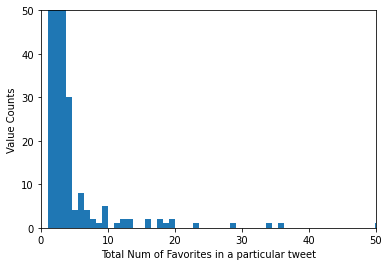

In [8]:
#
plt.hist(df_twitter['num_favorites'].value_counts(), bins=500)
plt.ylim(0, 50)
plt.xlim(0, 50)
plt.xlabel("Total Num of Favorites in a particular tweet")
plt.ylabel("Value Counts")
plt.show()

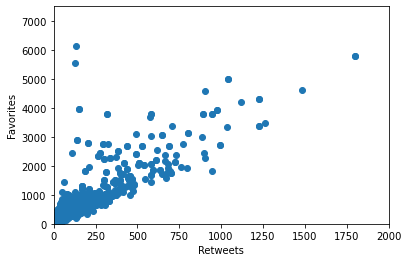

In [9]:
#Is there a reason to include both retweets and favorites if there is heteroscedasticity?
#Does this bring up Multicolinierity?
plt.scatter(df_twitter['num_retweets'],df_twitter['num_favorites'])
plt.ylim(0, 7500)
plt.xlim(0, 2000)
plt.xlabel("Retweets")
plt.ylabel("Favorites")
plt.show()

In [10]:
# Function to generate n-grams from sentences.
def extract_ngrams(text_lst, num):
    n_grams = ngrams(nltk.word_tokenize(' '.join(text_lst)), num)
    return [ ' '.join(grams) for grams in n_grams]

#Tokenize, Lowercase, and Filter Stopwords for Column in DataFrame
def tokenize(df, col_name):
    #Pull down stopwords and punctuation
    punctuation_ = set(string.punctuation)
    stopwords_ = set(stopwords.words('english'))
    
    #Use Snowball Stemmer for stemming
    stemmer_snowball = SnowballStemmer('english') 
    
    #Modify text
    df[col_name] = df[col_name].apply(lambda row: [w.split('://')[0] for w in row]) #Remove links 
    df[col_name] = df[col_name].apply(lambda row: word_tokenize(row)) #Tokenize (separate words)
    df[col_name] = df[col_name].apply(lambda row: [w.lower() for w in row]) #Lowercase
    df[col_name] = df[col_name].apply(lambda row: [w for w in row if not w in punctuation_]) #Remove Stopwords
    df[col_name] = df[col_name].apply(lambda row: [w for w in row if not w in stopwords_]) #Remove Punctuation
    df[col_name] = df[col_name].apply(lambda row: [stemmer_snowball.stem(w) for w in row]) #Stemming (taking words back to the basics)
    df[col_name] = df[col_name].apply(lambda row: extract_ngrams(row,1) + extract_ngrams(row,2)) #Add 2-Grams 
    df[col_name] = df[col_name].apply(lambda row: pos_tag(row))#Tag speech with noun/adj/verb/etc.
    
    
    return df

# Should I keep the hashtag symbol???

In [11]:
#Make all words lowercase
df_twitter['tokenized'] = df_twitter['text'].apply(lambda row: row.split('://')[0]) 

#Tokenize tweets
df_twitter['tokenized'] = df_twitter['tokenized'].apply(lambda row: word_tokenize(row)) 

#Make all words lowercase
df_twitter['tokenized'] = df_twitter['tokenized'].apply(lambda row: [word.lower() for word in row]) 

#Filter stopwords
stopwords_ = set(stopwords.words('english'))
punctuation_ = set(string.punctuation)
df_twitter['tokenized'] = df_twitter['tokenized'].apply(lambda row: [w for w in row if not w in punctuation_]) 

#Stemming
stemmer_snowball = SnowballStemmer('english')
df_twitter['tokenized'] = df_twitter['tokenized'].apply(lambda row: [stemmer_snowball.stem(word) for word in row]) 

#Add N-Grams
#df_twitter['tokenized'] = df_twitter['tokenized'].apply(lambda row: extract_ngrams(row, 1) + extract_ngrams(row, 2)) 

#Part-of-Speech tagging (create tuple of word and noun/verb/adj/etc.)
#df_twitter['tokenized'] = df_twitter['tokenized'].apply(lambda row: pos_tag(row)) 

In [12]:
#Vectorize the bag-of-words using TFIDF
def dummy_fun(doc):
    return doc

vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

vectors = vectorizer.fit_transform(df_twitter['tokenized'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_twitter_tfidf = pd.DataFrame(denselist, columns = feature_names)

In [13]:
df_twitter_tfidf.shape

(2640, 6211)

In [14]:
df_twitter_tfidf.iloc[4:8]

,'','d,'m,'s,+100,--,-/,-100,-3,-doctor,...,🤷‍♂️,🥧,🥧we,🥰,🥰🐀,🥰🚀,🥳,🥳🎆,🥺,🦸🏻
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.149820,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.137353,0.091855,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Supervised

In [52]:
#Create X and y variables 
X = df_twitter_tfidf
y = df_twitter['num_retweets'].apply(lambda x: 1 if x > 20 else 0) #Trending is greater than 20 retweets

In [61]:
#Train, test and split the data
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2)

In [ ]:
#Create base model for comparison


In [75]:
# Initialize the classificators
tree= DecisionTreeClassifier(random_state=1) # using the random state for reproducibility
forest= RandomForestClassifier(random_state=1)
knn= KNeighborsClassifier(n_neighbors=5)
xboost= XGBClassifier(random_state=1)
gboost = GradientBoostingClassifier(random_state=1) 
adaboost = AdaBoostClassifier(random_state=1)

In [76]:
# now, create a list with the objects 
models= [tree, forest, knn, xboost, gboost, adaboost]

for model in models:
    model.fit(X_train, y_train) # fit the model
    y_pred= model.predict(X_test) # predict on the test set
    accuracy= accuracy_score(y_test, y_pred) # model accuracy
    clf_report= classification_report(y_test, y_pred) # precision and recall 
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")

The accuracy of model DecisionTreeClassifier is 0.94
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       367
           1       0.89      0.91      0.90       161

    accuracy                           0.94       528
   macro avg       0.92      0.93      0.93       528
weighted avg       0.94      0.94      0.94       528



The accuracy of model RandomForestClassifier is 0.95
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       367
           1       0.95      0.89      0.92       161

    accuracy                           0.95       528
   macro avg       0.95      0.93      0.94       528
weighted avg       0.95      0.95      0.95       528



The accuracy of model KNeighborsClassifier is 0.89
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       367
           1       0.80      0.86      0.83       161

    accuracy         

/home/louisbove84/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:22:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy of model XGBClassifier is 0.95
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       367
           1       0.95      0.88      0.91       161

    accuracy                           0.95       528
   macro avg       0.95      0.93      0.94       528
weighted avg       0.95      0.95      0.95       528



The accuracy of model GradientBoostingClassifier is 0.91
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       367
           1       0.90      0.79      0.84       161

    accuracy                           0.91       528
   macro avg       0.91      0.88      0.89       528
weighted avg       0.91      0.91      0.91   

In [ ]:
#Precision = Accuracy of your positive predictions (TP/(TP+FP)) (Think Predictions)
#Recall = Accuracy of the positive samples (TP/(TP+FN))         (Think Truth)

# Unsupervised

# Pipeline